In [15]:
import string
import random
from random import randint
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
from scipy import ndimage 
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from skimage import transform

### Setup: set file paths

In [16]:
# MODEL_SAVE_PATH = '/home/fizzer/ros_ws/src/controller_pkg/assets/models/char_recog_resize'
MODEL_SAVE_PATH = '/home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/char_recog_resize_5'
MODEL_LOAD_PATH = '/home/fizzer/ros_ws/src/controller_pkg/assets/models/character_recognition'
MODEL_INPUT_SIZE = (20, 20)
LOAD_MODEL = False

# Part 1: Test generating single letter

In [17]:
chars = list(string.ascii_uppercase + string.digits)
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for i,c in enumerate(chars)}
print(ctoi)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


# Part 2: Generate list of image of each character

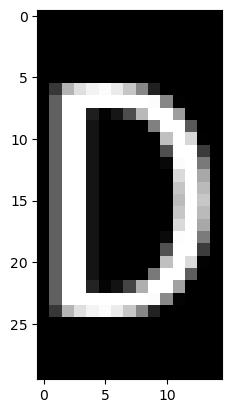

In [18]:
letter_images = []

FONT_HEIGHT = 30


for i in range(36):
    # zeros = np.zeros(shape=(int(FONT_HEIGHT * 2), int(FONT_HEIGHT * 1.5)), dtype=np.uint8)
    zeros = np.zeros(shape=(30,15), dtype=np.uint8)
    # plt.imshow(zeros)
    image = Image.fromarray(zeros)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(r"/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf", FONT_HEIGHT)
    text = itoc[i]
    # print(font.getsize(text))
    draw.text(xy=(0,0), text=text, font=font, fill=255)
    letter_image = np.array(image)
    letter_images.append(letter_image)

letter_images = np.stack([ im for im in letter_images], axis=0)
letter_images.shape

# show random one
plt.imshow(letter_images[np.random.randint(36)], cmap='gray')

## 2.2: Rotate images

/tmp/ipykernel_33534/1601131659.py:2: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  rotated = ndimage.interpolation.rotate(image, np.random.randint(-20,20), axes=(0,1), reshape=True)


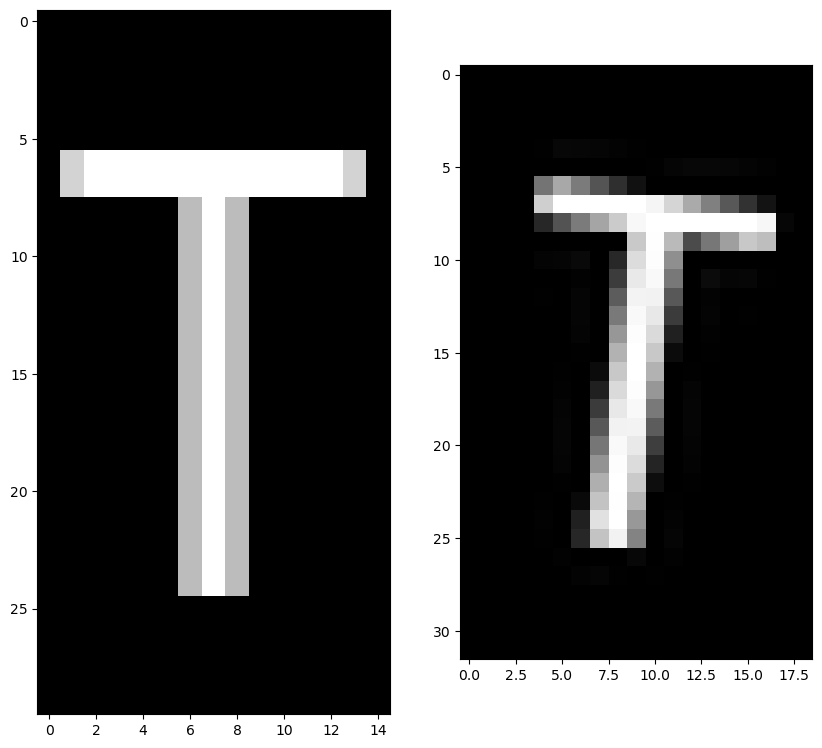

In [19]:
image = letter_images[np.random.randint(0,36)]
rotated = ndimage.interpolation.rotate(image, np.random.randint(-20,20), axes=(0,1), reshape=True)
# show random one 
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(rotated, cmap='gray')

## 2.4 Shear 

In [20]:
def unit_rand():
    return np.random.rand() * 2 - 1

/tmp/ipykernel_33534/3540206503.py:23: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  rotated = ndimage.interpolation.rotate(image, 90, axes=(0,1), reshape=True)
/tmp/ipykernel_33534/3540206503.py:29: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  unrotated = ndimage.interpolation.rotate(sheared, -90, axes=(0,1), reshape=True)


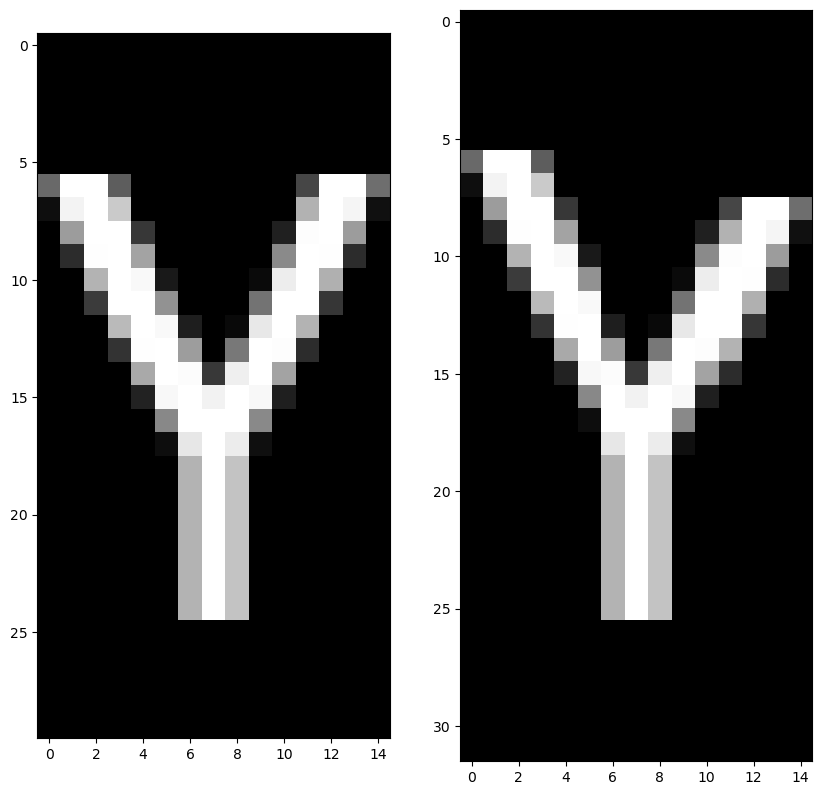

In [21]:
def shearNpImgByAngle(npImg, shearAngleDegrees, maxShearAngle=75): 
    import numpy as np
    from math import tan, radians
    assert -maxShearAngle <= shearAngleDegrees <= maxShearAngle
    npImg = np.rot90(npImg, 3) # rotate 270 degrees (counterclockwis
    ccw = True if shearAngleDegrees > 0 else False # shear counter-clockwise?
    imgH, imgW, = npImg.shape
    shearAngleRadians = radians(shearAngleDegrees)
    imgWplus2imgH = abs(tan(shearAngleRadians)) # (plus in width)/(image height)
    imgWplus      = int((imgH-1)*imgWplus2imgH)     # image width increase in pixels
    npImgOut = np.zeros((imgH, imgW+imgWplus), dtype='uint8')
    Wplus, Wplus2H = (0, -imgWplus2imgH) if ccw else (imgWplus,imgWplus2imgH) 
    for y in range(imgH):
        shiftX = Wplus-int(y*Wplus2H)
        npImgOut[y][shiftX:shiftX+imgW] = npImg[y]
    npImgOut = np.rot90(npImgOut, 1) # rotate 90 degrees (clockwise)
    return npImgOut



image = letter_images[np.random.randint(0,36)]
custom_sheared = shearNpImgByAngle(image, np.random.randint(-60,60))
rotated = ndimage.interpolation.rotate(image, 90, axes=(0,1), reshape=True)
shear_matrix = transform.AffineTransform(shear=np.random.rand()*2.0-1.0)
rotate = 1 if np.random.rand() > 0.5 else 0 
rotated = np.rot90(rotated, rotate*2)
sheared = transform.warp(rotated, shear_matrix, mode='constant', output_shape=(60,60), cval=0)
sheared = np.rot90(sheared, rotate*2)
unrotated = ndimage.interpolation.rotate(sheared, -90, axes=(0,1), reshape=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(custom_sheared, cmap='gray')

## 2.5 Random Blurring

#### Shrink down the size of the image to something like 10x8 pixels, then resize to original, creating random data losses

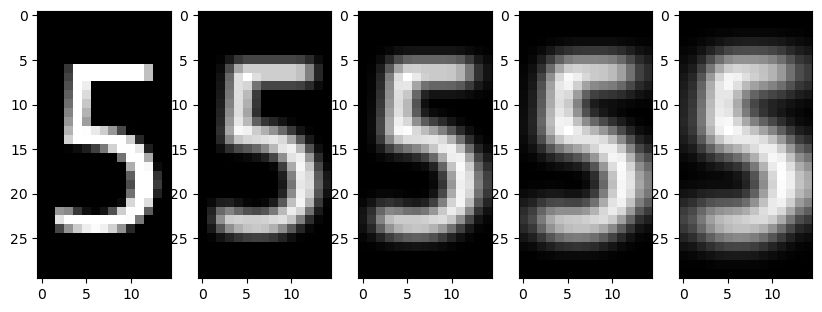

In [22]:
image = letter_images[np.random.randint(0,36)]
blur_3 = cv2.GaussianBlur(image, (3,3), 0)
blur_5 = cv2.GaussianBlur(image, (5,5), 0)
blur_7 = cv2.GaussianBlur(image, (7,7), 0)
blur_9 = cv2.GaussianBlur(image, (9,9), 0)

fig,axs = plt.subplots(1, 5, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(blur_3, cmap='gray')
axs[2].imshow(blur_5, cmap='gray')
axs[3].imshow(blur_7, cmap='gray')
axs[4].imshow(blur_9, cmap='gray')


# Part 3: Batch-ify it

In [23]:
RAND_RANGE = 0.6
ROTATION_RANGE_RADS = 1.0

X = np.empty(shape=(0, MODEL_INPUT_SIZE[0], MODEL_INPUT_SIZE[1])) 
Y = np.empty(shape=(0, 36))

for i in range(2000):
    crop_pixels = np.random.randint(2)
    # random shear 
    random_transform = transform.AffineTransform(rotation=np.random.rand()*ROTATION_RANGE_RADS - ROTATION_RANGE_RADS/2,translation=(crop_pixels, crop_pixels))
    # letter_images = [transform.warp(letter_images[i], random_transform, mode='constant', output_shape=(60,60), cval=0) for i in range(36)]
    shear_angle = np.random.randint(-60,60)
    sheared = [shearNpImgByAngle(letter_images[i], shear_angle) for i in range(36)]

    blur_factor = 1 + np.random.randint(1,6) * 2
    blurred = [cv2.GaussianBlur(sheared[i], (blur_factor,blur_factor), 0) for i in range(36)]
    # capture only image
    for i in range(len(blurred)):
        blurred_img = blurred[i]
        _, mask = cv2.threshold(blurred_img, 1, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        maxContour = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(maxContour)
        blurred[i] = cv2.resize(blurred[i][y+crop_pixels:y+h-crop_pixels, x+crop_pixels:x+w-crop_pixels], (MODEL_INPUT_SIZE[0], MODEL_INPUT_SIZE[1]))
    # vectorize
    results = np.stack(blurred, axis=0)
    labels = tf.one_hot(np.arange(36), depth=36)
    X = np.append(X, results, axis=0)
    Y = np.append(Y, labels, axis=0)
X.shape, Y.shape

((72000, 20, 20), (72000, 36))

## 3.1 Sample randomly to validate labels

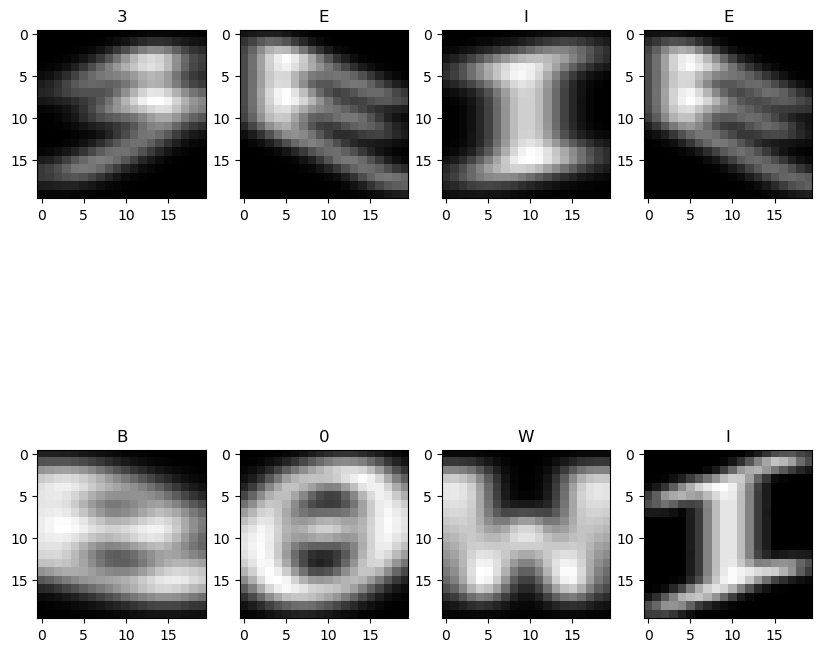

In [24]:
fig, axs = plt.subplots(2,4 , figsize=(10, 10))
for i in range(8):
    N = X.shape[0]
    n = np.random.randint(N)
    axs[i//4, i%4].imshow(X[n], cmap='gray')
    axs[i//4, i%4].set_title(itoc[np.argmax(Y[n])])


## 3.2: Data split

In [25]:
train_split = 0.9
N = X.shape[0]
n = int (N * train_split)
X_train = X[:n]
Y_train = Y[:n]
X_valid = X[n:]
Y_valid = Y[n:]

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(64800, 20, 20)
(64800, 36)
(7200, 20, 20)
(7200, 36)


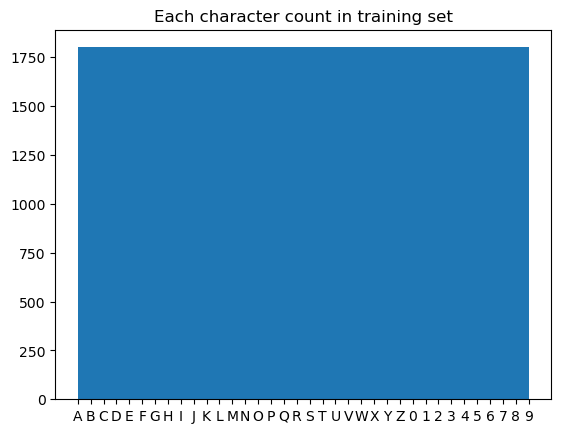

In [26]:
fig, axs = plt.subplots()
axs.hist(np.argmax(Y_train, axis=1), bins=36)
axs.set_title('Each character count in training set')
axs.set_xticks(range(36))
axs.set_xticklabels([c for c in list(ctoi.keys())])
print()

In [27]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(2,2), activation='relu', input_shape=(MODEL_INPUT_SIZE[0], MODEL_INPUT_SIZE[1], 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(36))
model.add(layers.Softmax())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 9, 9, 32)          320       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                102464    
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 64)               

In [28]:
EPOCHS = 2

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

if not LOAD_MODEL:
    history = model.fit(X_train, Y_train, epochs=EPOCHS, 
                        validation_data=(X_valid, Y_valid))
else:
    model = models.load_model(MODEL_LOAD_PATH)


Epoch 1/2
2025/2025 [==============================] - 9s 4ms/step - loss: 0.1478 - accuracy: 0.9595 - val_loss: 0.0159 - val_accuracy: 0.9953
Epoch 2/2
2025/2025 [==============================] - 8s 4ms/step - loss: 0.0257 - accuracy: 0.9934 - val_loss: 3.6618e-04 - val_accuracy: 0.9999


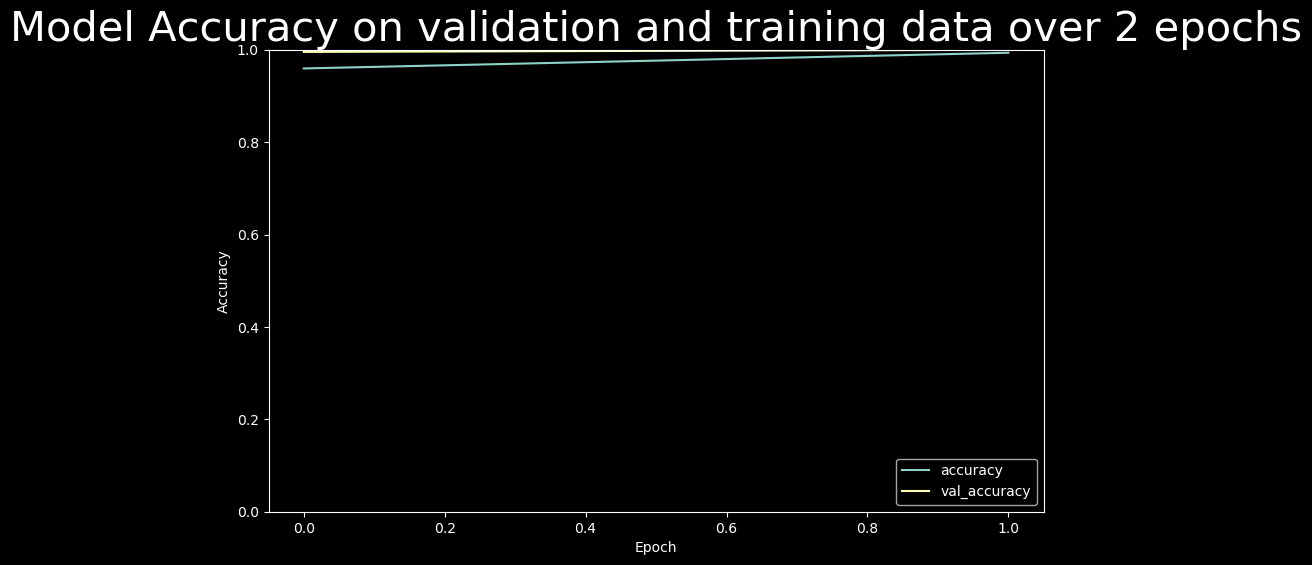

In [29]:

if not LOAD_MODEL:
    plt.style.use('dark_background')
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1.0])
    plt.legend(loc='lower right')
    plt.title(f"Model Accuracy on validation and training data over {EPOCHS} epochs", size=30)

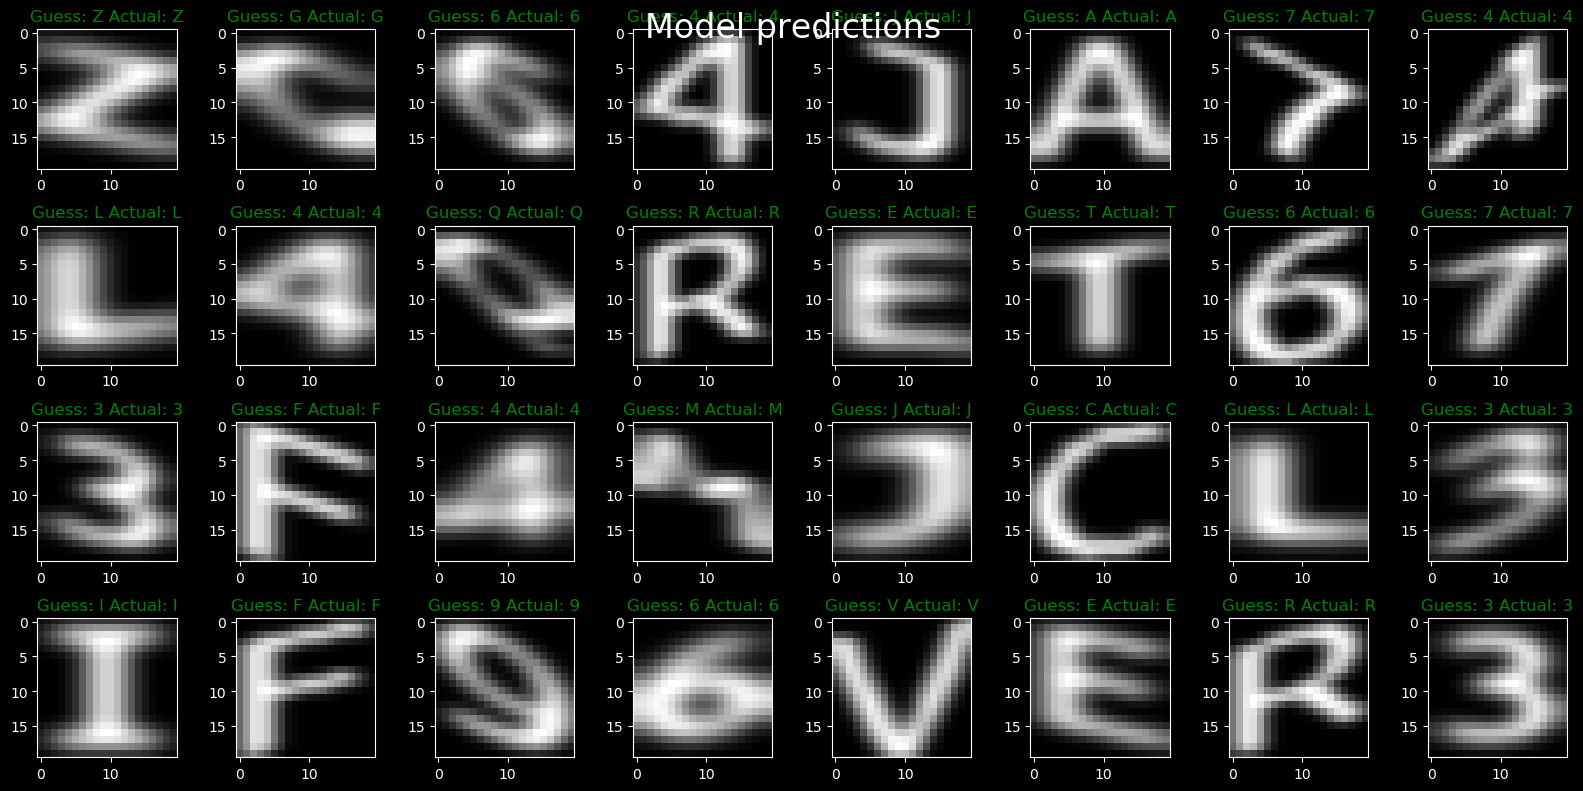

In [30]:

fig, axs = plt.subplots(4,8, figsize=(16,8))
for i in range(32):
    n = np.random.randint(X_valid.shape[0])
    input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
    label = itoc[np.argmax(Y_valid[n])]
    ypred = str(itoc[np.argmax(model(input))])
    axs[i//8, i%8].imshow(X_valid[n], cmap='gray')
    if label == ypred:
        axs[i//8, i%8].set_title('Guess: ' + str(ypred) + ' Actual: ' + label, color='green')
    else:
        axs[i//8, i%8].set_title('Guess: ' + str(ypred) + ' Actual: ' + str(label), color='red')
fig.suptitle('Model predictions', fontsize=24)
fig.tight_layout()

In [31]:
model.save(MODEL_SAVE_PATH)

INFO:tensorflow:Assets written to: /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/char_recog_resize_5/assets


INFO:tensorflow:Assets written to: /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/char_recog_resize_5/assets


In [32]:
%%timeit -r 16 -n 16 
n = np.random.randint(X_valid.shape[0])
input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
label = itoc[np.argmax(Y_valid[n])]
ypred = str(itoc[np.argmax(model(input))])
# print(ypred)

1.62 ms ± 111 µs per loop (mean ± std. dev. of 16 runs, 16 loops each)


: 